# **House Price Prediction**

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from utils import handle_data

import warnings
warnings.filterwarnings("ignore")

In [59]:
data = pd.read_csv("data/train.csv")
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [60]:
test = pd.read_csv("data/test.csv")
print(test.shape)

(1459, 80)


## *Types of Features:*

In [61]:
train_pre = handle_data(data = data) 
test_pre = handle_data(data = test)

In [62]:
num, cat, cont, disc, yr = train_pre.extract_var()
print("Numerical : "+str(len(num))+", Categorical "+
      str(len(cat)) + ", Continuous: " + str(len(cont))+ ", Discrete: " + str(len(disc)))

Numerical : 38, Categorical 43, Continuous: 18, Discrete: 14


## **Feature Engineering section**

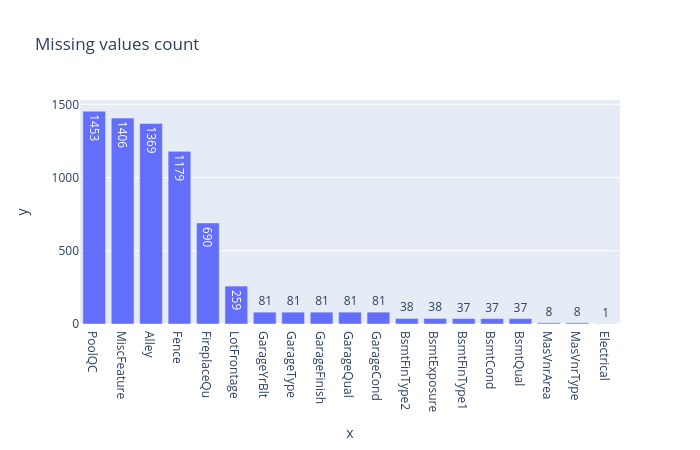

In [63]:
train_pre.plot_missing(png=True)

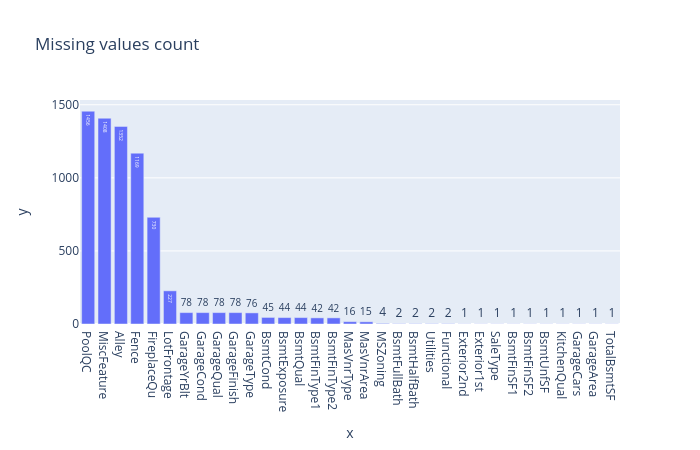

In [64]:
test_pre.plot_missing(png = True)

***Operations:***

In [65]:
#Dropping the column with most of the values being null and also by imputing others using sklearn.Imputer()
data = data.drop(columns = ['PoolQC', 'MiscFeature','Alley','Fence','FireplaceQu'])
test = test.drop(columns = ['PoolQC', 'MiscFeature','Alley','Fence','FireplaceQu'])
train_pre = handle_data(data = data) 
test_pre = handle_data(data = test)

In [66]:
#Updating the columns in different types of variables
num, cat, cont, disc, yr = train_pre.extract_var()
num_test, cat_test, cont_test, disc_test, yr_test = test_pre.extract_var()

In [67]:
#For Categorical data
train_pre.check_for_missing(cat)

MasVnrType : 8/1460
BsmtQual : 37/1460
BsmtCond : 37/1460
BsmtExposure : 38/1460
BsmtFinType1 : 37/1460
BsmtFinType2 : 38/1460
Electrical : 1/1460
GarageType : 81/1460
GarageFinish : 81/1460
GarageQual : 81/1460
GarageCond : 81/1460

 Done Checking !


In [68]:
#For numerical data
train_pre.check_for_missing(cont)

LotFrontage : 259/1460
MasVnrArea : 8/1460

 Done Checking !


In [69]:
train_pre.Imputation(cont,stats=False)

Imputation over continuous and categorical only
Imputer Fitted and Transformed!


In [70]:
train_pre.Imputation(cat,stats=False)

Imputer Fitted and Transformed!


In [71]:
test_pre.Imputation(cat_test,stats=False)

Imputer Fitted and Transformed!


In [72]:
test_pre.Imputation(cont_test,stats=False)

Imputation over continuous and categorical only
Imputer Fitted and Transformed!


In [73]:
print(data.shape, test.shape)

(1460, 76) (1459, 75)


## (B) Handling High Cardinality and Rare Labels

In [74]:
multi_cat_cols = []

for col in data[cat].columns:
        if data[col].nunique() > 10: 
            multi_cat_cols.append(col)  
            print(col)
            #print(data[cat].groupby(col)[col].count()/ len(data[cat]))

Neighborhood
Exterior1st
Exterior2nd


In [75]:
train_pre.find_non_rare_labels('Neighborhood', 0.05)

['CollgCr',
 'Edwards',
 'Gilbert',
 'NAmes',
 'NridgHt',
 'OldTown',
 'Sawyer',
 'Somerst']

In [76]:
for variable in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    data = train_pre.rare_encoding(variable, 0.05)
    test = test_pre.rare_encoding(variable, 0.05)

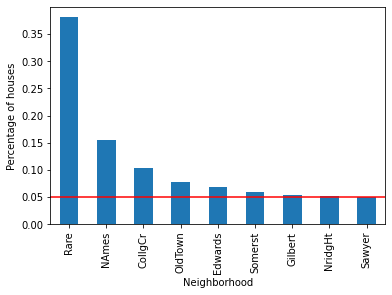

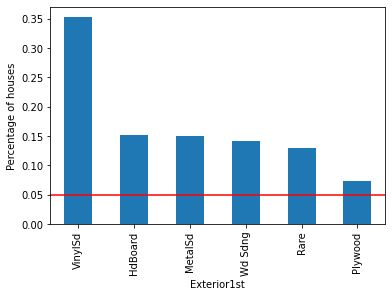

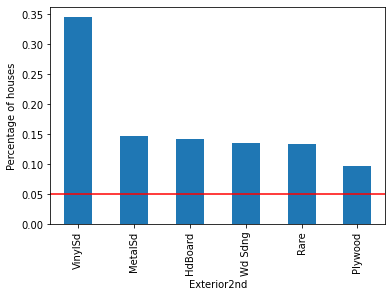

In [77]:
for col in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    temp_df = pd.Series(data[col].value_counts() / len(data) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

In [78]:
print(data.shape, test.shape)

(1460, 76) (1459, 75)


## (C) Outliers

Train Data


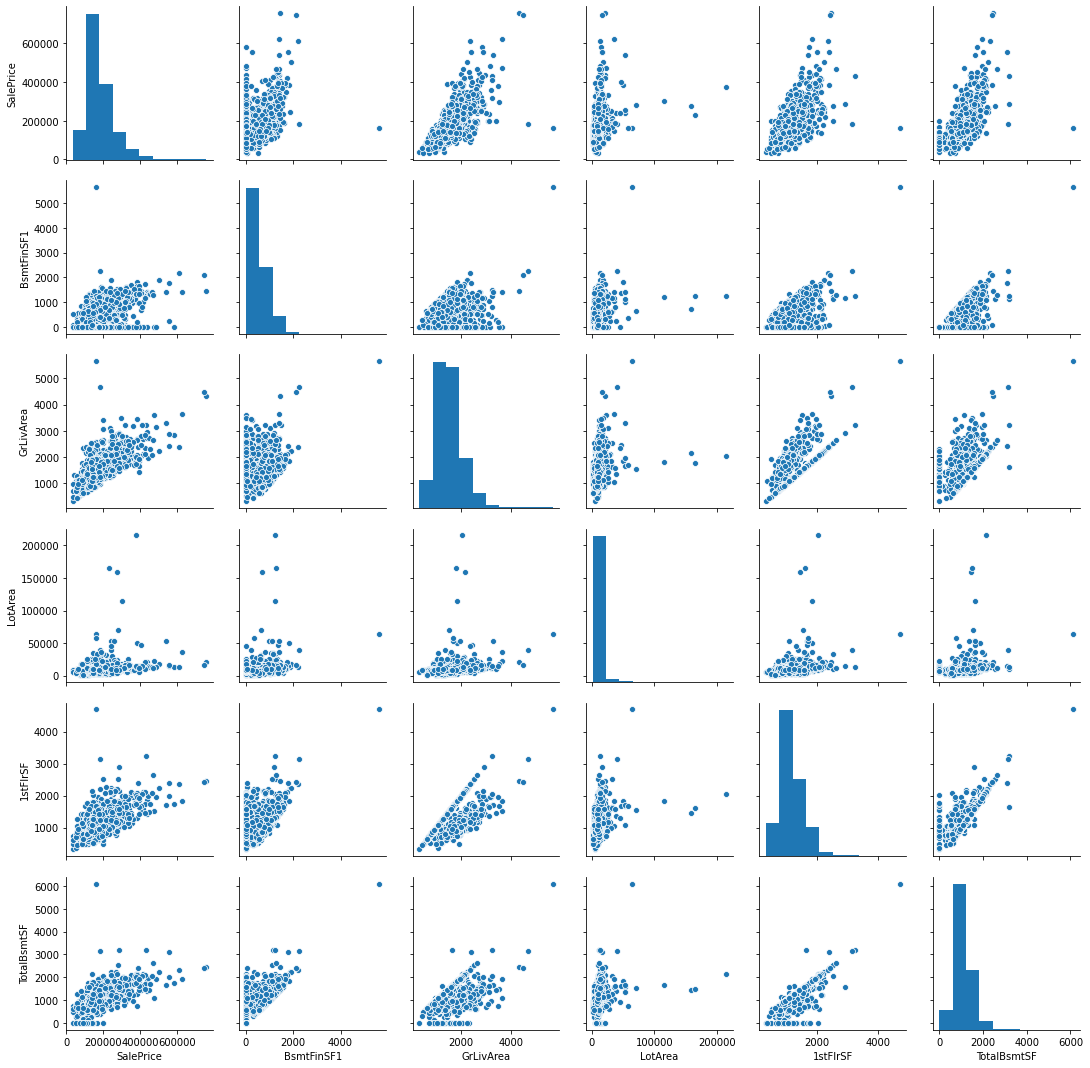

In [79]:
print("Train Data")
cols = ['SalePrice', 'BsmtFinSF1', 'GrLivArea', 'LotArea','1stFlrSF','TotalBsmtSF']
sns.pairplot(data[cols], size = 2.5);

In [80]:
outliers = data[
    (data['GrLivArea'] > 4000) &
    (data['SalePrice'] < 300000)&
    (data['LotArea'] > 100000) &
    (data['TotalBsmtSF'] > 3000) &
    (data['1stFlrSF'] > 2500)]

data.drop(outliers.index, inplace=True)


In [81]:
outliers = test[
    (test['GrLivArea'] > 4000) &
    (test['LotArea'] > 100000) &
    (test['TotalBsmtSF'] > 3000) &
    (test['1stFlrSF'] > 2500)
]

test.drop(outliers.index, inplace=True)
    


In [82]:
#Functions with Updated data !
train_pre = handle_data(data = data) 
test_pre = handle_data(data = test)

In [83]:
print(data.shape, test.shape)

(1460, 76) (1459, 75)


## (D) Skewness:

### SalePrice

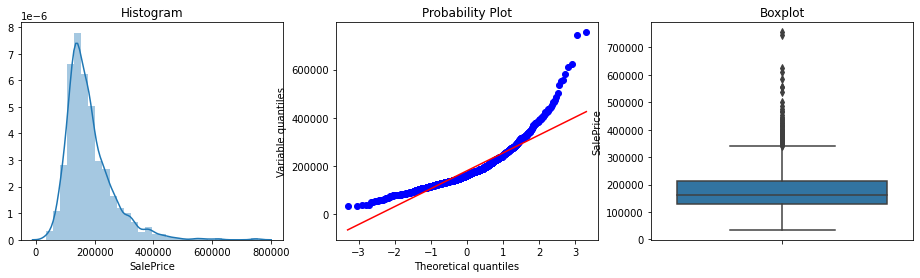

In [84]:
train_pre.diagnostic_plots('SalePrice')

##### ***The Saleprice is skewed and needs to be transformed***

In [85]:
print("Skewness: " + str(data['SalePrice'].skew()))
print("Kurtosis: " + str(data['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [86]:
#Log Transformation: log(1+x)
data["SalePrice"] = np.log1p(data["SalePrice"])
train_pre = handle_data(data = data)

After Transformation of log(1 + x)


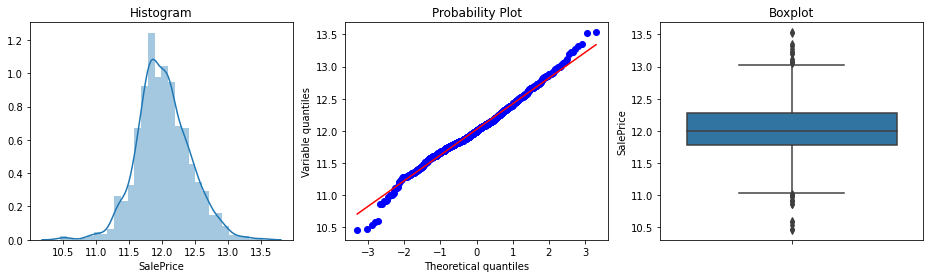

In [87]:
print("After Transformation of log(1 + x)")
train_pre.diagnostic_plots('SalePrice')

### 1stFlrSF

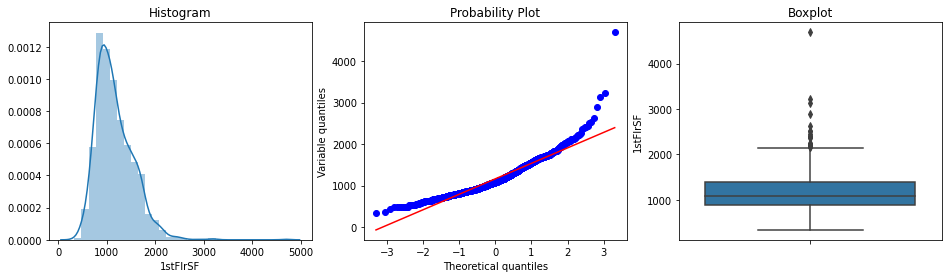

In [88]:
train_pre.diagnostic_plots('1stFlrSF')

In [89]:
#For complete data
train_pre.fixing_skewness()
test_pre.fixing_skewness()

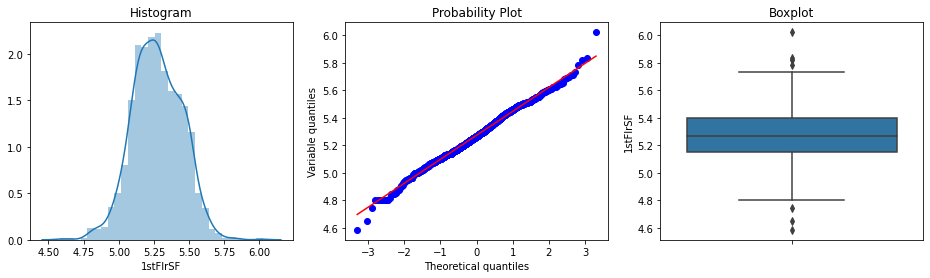

In [90]:
train_pre.diagnostic_plots('1stFlrSF')

In [91]:
print(data.shape, test.shape)

(1460, 76) (1459, 75)


## (E) Heatmaps and Correlation

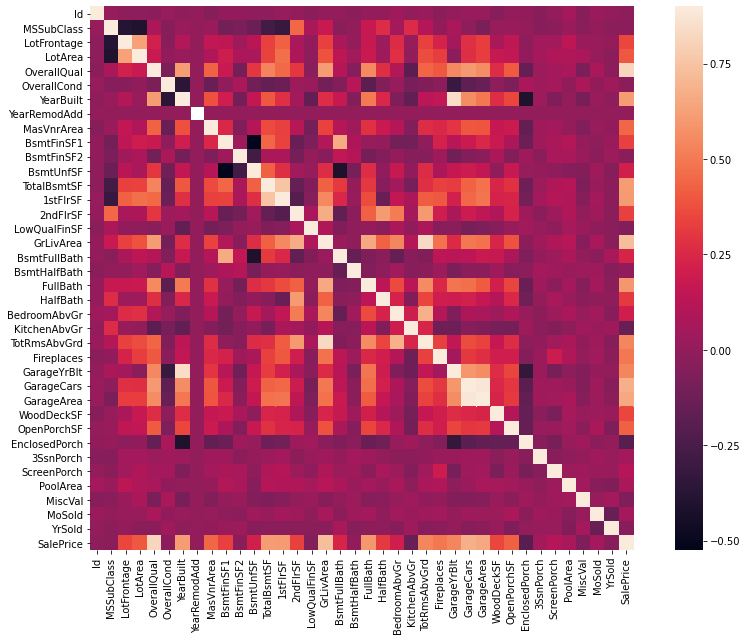

In [92]:
corr_matrix = data.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix, vmax=0.9, square=True)

In [93]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [94]:
data[cat] = ordinal_encoder.fit_transform(data[cat])
test[cat_test] = ordinal_encoder.fit_transform(test[cat_test])

In [95]:
num, cat, cont, disc, yr = train_pre.extract_var()
print("Numerical : "+str(len(num))+", Categorical "+
      str(len(cat)) + ", Continuous: " + str(len(cont))+ ", Discrete: " + str(len(disc)))

Numerical : 76, Categorical 0, Continuous: 18, Discrete: 52


In [96]:
num_test, cat_test, cont_test, disc_test, yr_test = test_pre.extract_var()
print("Numerical : "+str(len(num_test))+", Categorical "+
      str(len(cat_test)) + ", Continuous: " + str(len(cont_test))+ ", Discrete: " + str(len(disc_test)))

Numerical : 75, Categorical 0, Continuous: 16, Discrete: 54


In [97]:
train_pre.check_for_missing(num)

GarageYrBlt : 81/1460

 Done Checking !


In [98]:
test_pre.check_for_missing(num_test)

BsmtFullBath : 2/1459
BsmtHalfBath : 2/1459
GarageYrBlt : 78/1459
GarageCars : 1/1459

 Done Checking !


In [99]:
data.fillna(0, inplace = True)
test.fillna(0, inplace = True)

In [100]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,6.281283,3.0,9.646419,8.670456,1.0,3.0,3.0,0.0,4.0,...,0.000000,0.0,0.0,0.0,0.0,2,2008,8.0,4.0,12.247699
1,2,4.146687,3.0,10.586092,8.787629,1.0,3.0,3.0,0.0,2.0,...,0.000000,0.0,0.0,0.0,0.0,5,2007,8.0,4.0,12.109016
2,3,6.281283,3.0,9.844617,8.933083,1.0,0.0,3.0,0.0,4.0,...,0.000000,0.0,0.0,0.0,0.0,9,2008,8.0,4.0,12.317171
3,4,6.622580,3.0,9.302748,8.782836,1.0,0.0,3.0,0.0,0.0,...,19.032388,0.0,0.0,0.0,0.0,2,2006,8.0,0.0,11.849405
4,5,6.281283,3.0,10.817369,9.150118,1.0,0.0,3.0,0.0,2.0,...,0.000000,0.0,0.0,0.0,0.0,12,2008,8.0,4.0,12.429220


In [101]:
#Functions with Updated data !
train_pre = handle_data(data = data) 
test_pre = handle_data(data = test)

In [102]:
print(data.shape, test.shape)

(1460, 76) (1459, 75)


## **Machine learning section**

In [103]:
from sklearn.model_selection import train_test_split , KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [104]:
y = data.SalePrice.reset_index(drop=True)
X = data.drop(['SalePrice'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)

In [105]:
print(X.shape, y.shape, data.shape, test.shape)

(1460, 75) (1460,) (1460, 76) (1459, 75)


### Linear Regression

In [106]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)
y_train_pred = regr.predict(X_train)

In [107]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.113, test: 0.106
R^2 train: 0.309, test: 0.297


### Lasso Regression 

In [108]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred_1 = lasso.predict(X_train)
y_test_pred_1= lasso.predict(X_test)
#print(lasso.coef_)

In [109]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred_1),
        mean_squared_error(y_test, y_test_pred_1)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred_1),
        r2_score(y_test, y_test_pred_1)))

MSE train: 0.039, test: 0.046
R^2 train: 0.759, test: 0.693


### XGBoost

In [110]:
import xgboost

xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
xgb.fit(X_train,y_train)
y_test_pred_2 = xgb.predict(X_test)
y_train_pred_2= xgb.predict(X_train)


[12:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [111]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred_2),
        mean_squared_error(y_test, y_test_pred_2)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred_2),
        r2_score(y_test, y_test_pred_2)))


MSE train: 0.001, test: 0.015
R^2 train: 0.995, test: 0.901


# Submission

In [112]:
y_pred = xgb.predict(test)
final_predictions = np.exp(y_pred)

submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": final_predictions
    })

submission.to_csv("xgb.csv", encoding='utf-8', index=False)

print(submission.head())

     Id      SalePrice
0  1461  117228.437500
1  1462  163787.593750
2  1463  186968.375000
3  1464  187844.843750
4  1465  214857.640625


# END